In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re

from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Embedding, GlobalMaxPooling1D, Dropout, LSTM, Activation, Bidirectional, Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.metrics import categorical_accuracy, categorical_crossentropy

from sklearn.dummy import DummyClassifier
from sklearn.metrics import hamming_loss
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_similarity_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [2]:


BASE_PATH = ''
EMBEDDINGS_PATH = os.path.abspath("C:/Users/Muhammad/Deep Learning/Final Project/Glove")
GLOVE_PATH = os.path.join(EMBEDDINGS_PATH, "glove.twitter.27B.50d.txt")
EMBEDDING_DIMENSION = 50
MAX_TWEET_LENGTH = 350
MAX_VOCAB = 20000
BATCH_SIZE = 64
LEARNING_RATE = 0.001
FLAGS = re.MULTILINE | re.DOTALL


In [3]:


def fix_split(pattern, string):
    splits = list((m.start(), m.end()) for m in re.finditer(pattern, string))
    starts = [0] + [i[1] for i in splits]
    ends = [i[0] for i in splits] + [len(string)]
    return [string[start:end] for start, end in zip(starts, ends)]


def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = " {} ".format(hashtag_body.lower())
    else:
        result = " ".join(["<hashtag>"] + fix_split(r"(?=[A-Z])", hashtag_body))  # , flags=FLAGS))
    return result


def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"


def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"/", " / ")
    text = re_sub(r"<3", "<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\S+", hashtag)
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")
    text = re_sub(r"([A-Z]){2,}", allcaps)

    return text.lower()


def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


def avg_tweet_length(frame, column):
    return len(frame[column].str.cat(sep=' ').split()) / len(frame[column])


def build_bi_directional_lstm_nn(embed_layer, y_train):
    tweet_input = Input(shape=(MAX_TWEET_LENGTH,), dtype='int32')
    embedded_tweets = embed_layer(tweet_input)
    m = Bidirectional(LSTM(24, return_sequences=True))(embedded_tweets)
    m = Bidirectional(LSTM(24))(m)
    output = Dense(y_train.shape[1], activation='sigmoid')(m)
    bi_model = Model(tweet_input, output)
    bi_model.compile(loss='binary_crossentropy',
                     optimizer=Adam(LEARNING_RATE),
                     metrics=['categorical_accuracy'])
    return bi_model


def build_lstm_nn(embed_layer, y_train):
    tweet_input = Input(shape=(MAX_TWEET_LENGTH,), dtype='int32')
    embedded_tweets = embed_layer(tweet_input)
    m = LSTM(24, activation='relu', return_sequences=True, dropout=0.6, recurrent_dropout=0.0)(embedded_tweets)
    m = LSTM(12, activation='relu', dropout=0.4)(m)
    output = Dense(y_train.shape[1], activation='sigmoid')(m)
    lstm_model = Model(tweet_input, output)
    lstm_model.compile(loss='binary_crossentropy',
                       optimizer=Adam(LEARNING_RATE),
                       metrics=['categorical_accuracy'])
    return lstm_model


def build_basic_nn(embed_layer, y_train):
    tweet_input = Input(shape=(MAX_TWEET_LENGTH,), dtype='int32')

    embedded_tweets = embed_layer(tweet_input)
    m = GlobalMaxPooling1D()(embedded_tweets)
    m = Dense(24, activation='relu')(m)
    m = Dense(12, activation='relu')(m)
    output = Dense(y_train.shape[1], activation='sigmoid')(m)

    basic_model = Model(tweet_input, output)
    basic_model.compile(loss='binary_crossentropy', metrics=['categorical_accuracy'],
                        optimizer=Adam(LEARNING_RATE))
    return basic_model

# to experiment with specifically classifying neutral tweets (not used for final results)
def add_no_emo(frame, emos):
    frame['no_emotion'] = frame[emos].sum(axis=1)
    frame['no_emotion'] = np.where(frame['no_emotion'] == 0, 1, 0)
    return frame


In [4]:
labeling_data = pd.read_csv("C:/Users/Muhammad/Deep Learning/Final Project/To Label Data/Pre-processed_English_Tweets.csv")
labeling_data['text'] = labeling_data['text'].fillna("")

In [5]:
print ('Data loading')
train_df = pd.read_csv('C:/Users/Muhammad/Deep Learning/Final Project/SemEval2018-Task1-all-data/English/E-c/train.txt', sep = '\t')
test_df = pd.read_csv('C:/Users/Muhammad/Deep Learning/Final Project/SemEval2018-Task1-all-data/English/E-c/test.txt', sep = '\t')
val_df = pd.read_csv('C:/Users/Muhammad/Deep Learning/Final Project/SemEval2018-Task1-all-data/English/E-c/dev.txt', sep = '\t')



print ('Data loaded...')

df = train_df.append(val_df, ignore_index=True)
df = df.append(test_df, ignore_index = True)

# Clean up training data
# df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df['text'] = df['text'].apply(tokenize)
emotions = df.columns[11:]

Data loading
Data loaded...


In [6]:
emotions

Index(['surprise', 'trust'], dtype='object')

In [10]:
tweets = df['text']
# tweets = tweets.append(labeling_data['text'])

In [11]:
# len(tweets), df['text'].shape, labeling_data['text'].shape

In [12]:
tweets= list(tweets.values)
tokenizer = Tokenizer(num_words=MAX_VOCAB, filters='!"$%&()*+,-./:;?@[\]^_`{|}~')
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens')


data = pad_sequences(sequences, maxlen=MAX_TWEET_LENGTH)

# ## to_label Data
# to_predict_tokens = data[:232070]
# ## train_test Data
# data = data[232070:]


Found 19285 unique tokens


In [13]:

# build dictionary from glove embeddings .txt file
embedding_index = {}
with open(GLOVE_PATH, encoding = 'utf-8') as f:
    for index, line in enumerate(f):
        elements = line.split()
        word = elements[0]
        coefs = np.asarray(elements[1:], dtype=np.float32)
        embedding_index[word] = coefs
        if index + 1 == 900:
            break

In [15]:
# data.shape, to_predict_tokens.shape

Shape of data tensor: (10983, 350)
Shape of label tensor: (10983, 2)
Preparing embedding matrix....
Epoch 1/100
121/121 - 62s - loss: 0.2531 - categorical_accuracy: 0.5620 - val_loss: 0.2055 - val_categorical_accuracy: 0.9517
Epoch 2/100
121/121 - 58s - loss: 0.2000 - categorical_accuracy: 0.7015 - val_loss: 0.2056 - val_categorical_accuracy: 0.0525
Epoch 3/100
121/121 - 58s - loss: 0.1998 - categorical_accuracy: 0.5155 - val_loss: 0.2063 - val_categorical_accuracy: 0.9369
Epoch 4/100
121/121 - 58s - loss: 0.1993 - categorical_accuracy: 0.6644 - val_loss: 0.2037 - val_categorical_accuracy: 0.3229
Epoch 5/100
121/121 - 57s - loss: 0.1975 - categorical_accuracy: 0.4997 - val_loss: 0.2020 - val_categorical_accuracy: 0.4461
Epoch 6/100
121/121 - 63s - loss: 0.1956 - categorical_accuracy: 0.5221 - val_loss: 0.2028 - val_categorical_accuracy: 0.2731
Epoch 7/100
121/121 - 64s - loss: 0.1936 - categorical_accuracy: 0.5398 - val_loss: 0.2030 - val_categorical_accuracy: 0.3387
Epoch 8/100
121/12

Epoch 65/100
121/121 - 39s - loss: 0.0406 - categorical_accuracy: 0.6197 - val_loss: 0.3768 - val_categorical_accuracy: 0.6124
Epoch 66/100
121/121 - 37s - loss: 0.0371 - categorical_accuracy: 0.6272 - val_loss: 0.3706 - val_categorical_accuracy: 0.5961
Epoch 67/100
121/121 - 37s - loss: 0.0388 - categorical_accuracy: 0.6050 - val_loss: 0.3760 - val_categorical_accuracy: 0.5894
Epoch 68/100
121/121 - 37s - loss: 0.0643 - categorical_accuracy: 0.6240 - val_loss: 0.3599 - val_categorical_accuracy: 0.6564
Epoch 69/100
121/121 - 37s - loss: 0.0425 - categorical_accuracy: 0.6336 - val_loss: 0.3677 - val_categorical_accuracy: 0.6012
Epoch 70/100
121/121 - 37s - loss: 0.0372 - categorical_accuracy: 0.6217 - val_loss: 0.3858 - val_categorical_accuracy: 0.6258
Epoch 71/100
121/121 - 37s - loss: 0.0431 - categorical_accuracy: 0.6318 - val_loss: 0.3695 - val_categorical_accuracy: 0.5857
Epoch 72/100
121/121 - 37s - loss: 0.0403 - categorical_accuracy: 0.6110 - val_loss: 0.3794 - val_categorical_a

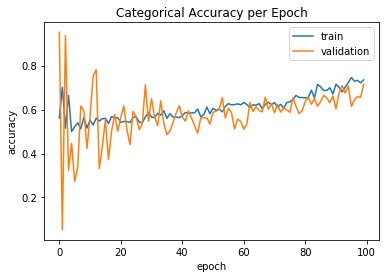

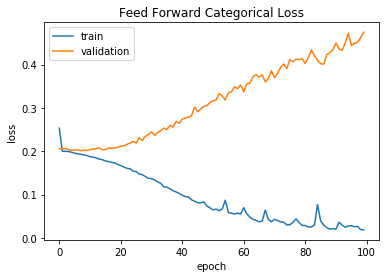

predictions [[False False]
 [False False]
 [False False]
 ...
 [False False]
 [False False]
 [False False]]
Predicted Results:
[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


########### RESULTS ###########
Dummy (random predictor) score: 0.8212443095599393
Dummy (most frequent predictor) score 0.8992412746585736

Actual Accuracies:
Jaccard Similarity (accuracy): 0.804855842185129
Classification Report: 
              precision    recall  f1-score   support

    surprise       0.06      0.08      0.07       172
       trust       0.12      0.15      0.13       172

   micro avg       0.09      0.11      0.10       344
   macro avg       0.09      0.11      0.10       344
weighted avg       0.09      0.11      0.10       344
 samples avg       0.01      0.01      0.01       344

Precision Score (micro): 0.09026128266033254
Precision Score (macro): 0.09173450927182271
Recall Score (micro): 0.11046511627906977
Recall Score (macro): 0.11046511627906977
f1 Score (micro): 0.099346405228758

C:\Users\Muhammad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
C:\Users\Muhammad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Muhammad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:

            
            
# print ('Data loading')
# train_df = pd.read_csv('C:/Users/Muhammad/Deep Learning/Final Project/Human labeled data/Human_labeled_Emotion_tweets_processed/train.csv')
# test_df = pd.read_csv('C:/Users/Muhammad/Deep Learning/Final Project/Human labeled data/Human_labeled_Emotion_tweets_processed/test.csv')
# val_df = pd.read_csv('C:/Users/Muhammad/Deep Learning/Final Project/Human labeled data/Human_labeled_Emotion_tweets_processed/dev.csv')



# print ('Data loaded...')

# df = train_df.append(val_df, ignore_index=True)
# df = df.append(test_df, ignore_index = True)
# # Clean up training data
# # df.dropna(axis=0, inplace=True)
# df.reset_index(drop=True, inplace=True)
# df['text'] = df['text'].apply(tokenize)
# emotions = df.columns[11:]


# # turn tweets into 2D integer tensors
# tweets = list(df['text'].values)
# tokenizer = Tokenizer(num_words=MAX_VOCAB, filters='!"$%&()*+,-./:;?@[\]^_`{|}~')
# tokenizer.fit_on_texts(tweets)
# sequences = tokenizer.texts_to_sequences(tweets)
# word_index = tokenizer.word_index
# print(f'Found {len(word_index)} unique tokens')

# data = pad_sequences(sequences, maxlen=MAX_TWEET_LENGTH)

# emotions_dict = dict(enumerate(emotions))
labels = df[emotions].values
print(f'Shape of data tensor: {data.shape}')
print(f'Shape of label tensor: {labels.shape}')

# split the data into a training set and a validation set
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.3)

# prepare embedding matrix
print('Preparing embedding matrix....')

num_words = min(MAX_VOCAB, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIMENSION))
for word, i in word_index.items():
    if i >= MAX_VOCAB:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIMENSION,
                            weights=[embedding_matrix],
                            input_length=MAX_TWEET_LENGTH,
                            trainable=False)

# Choose Model
# model = build_basic_nn(embedding_layer, y_train)
# model = build_lstm_nn(embedding_layer, y_train)
model = build_bi_directional_lstm_nn(embedding_layer, y_train)

# uncomment to to make use of 'early stopping'
"""
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=75, verbose=1, mode='min')
check_pointer = ModelCheckpoint(filepath="multi_label_best_weights.hdf5",
                                verbose=0, save_best_only=True)  # save best model
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, validation_data=(x_val, y_val),
                    callbacks=[monitor, check_pointer], verbose=2, epochs=200)
"""

# fit model to training data and record learning curve info for training and testing scores
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, validation_data=(x_val, y_val),
                    verbose=2, epochs=100)

# only use if early stopping is enabled
# model.load_weights('multi_label_best_weights.hdf5')  # load weights from best model

# plot accuracy learning curves
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Categorical Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# plot_acc_file = 'plots/model_accuracy/' + timestamp + '.eps'
# plt.savefig(plot_acc_file, format='eps', dpi=1000)

plt.show()

# plot loss learning curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Feed Forward Categorical Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
# plot_loss_file = 'plots/model_loss' + timestamp + '.eps'
# plt.savefig(plot_loss_file, format='eps', dpi=1000)
plt.show()

# Turn probabilities into predictions and compare with ground truth
predictions = model.predict(x_val)
mask = predictions > .2
print ('predictions',mask)
predicted_classes = mask.astype(int)
print(f"Predicted Results:")
print(f"{predicted_classes}")

print()
print()
print('########### RESULTS ###########')

# dummy classifier that chooses randomly
clf_strat = DummyClassifier(strategy='stratified')
clf_strat.fit(x_train, y_train)
dummy_score_strat = clf_strat.score(x_val, y_val)
print(f"Dummy (random predictor) score: {dummy_score_strat}")

# dummy classifier that chooses the most frequent label
clf_freq = DummyClassifier(strategy='most_frequent')
clf_freq.fit(x_train, y_train)
most_freq = np.zeros_like(predicted_classes)
print(f"Dummy (most frequent predictor) score {jaccard_similarity_score(y_val, most_freq)}")

# calculate various metrics
print("\nActual Accuracies:")
jaccard_sim = jaccard_similarity_score(y_val, predicted_classes)
prec_score_micro = precision_score(y_val, predicted_classes, average='micro')
prec_score_macro = precision_score(y_val, predicted_classes, average='macro')
rec_score_micro = recall_score(y_val, predicted_classes, average='micro')
rec_score_macro = recall_score(y_val, predicted_classes, average='macro')
f1_micro = f1_score(y_val, predicted_classes, average='micro')
f1_macro = f1_score(y_val, predicted_classes, average='macro')
ham_loss = hamming_loss(y_val, predicted_classes)
class_report = classification_report(y_val, predicted_classes, target_names=emotions)

# print accuracies
print(f"Jaccard Similarity (accuracy): {jaccard_sim}")
print(f"Classification Report: \n{class_report}")
print(f"Precision Score (micro): {prec_score_micro}")
print(f"Precision Score (macro): {prec_score_macro}")
print(f"Recall Score (micro): {rec_score_micro}")
print(f"Recall Score (macro): {rec_score_macro}")
print(f"f1 Score (micro): {f1_micro}")
print(f"f1 Score (macro): {f1_macro}")
print(f"Hamming Loss: {ham_loss}")


In [17]:
print ("Prediction Accuracy:", accuracy_score(y_val, predicted_classes))

Prediction Accuracy: 0.8045523520485585


In [13]:
label_list = ['anger','anticipation','disgust','fear','joy','love','optimism','pessimism','sadness','surprise','trust']

In [14]:
result = model.predict(to_predict_tokens)
mask = result > .2
labels = mask.astype(int)

In [29]:
results = pd.merge(pd.DataFrame(labeling_data), pd.DataFrame(labels, columns=label_list), left_index=True, right_index=True)

In [32]:
results.to_csv("C:/Users/Muhammad/Deep Learning/Final Project/To Label Data/Keras_LSTM_labeled.csv", index =False)

In [30]:
results

,status_id,user_id,date,time,text,is_quote,display_text_width,favorite_count,retweet_count,hashtags,...,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,1240849521011113984,840438614,2020-03-20,03:55:54,corona time,False,43,0,0,NaN,...,0,0,0,0,0,1,1,0,1,0
1,1240849520381976576,1143505456121307136,2020-03-20,03:55:54,flexing king u+0001f525,True,16,0,0,NaN,...,0,0,0,0,0,0,0,1,0,0
2,1240849519727857664,3449353153,2020-03-20,03:55:54,everyone looks sick,False,67,0,51508,NaN,...,0,1,0,0,0,0,0,0,0,0
3,1240849521866952704,1511537016,2020-03-20,03:55:54,corona day 3 feels like sunday,False,73,0,89818,NaN,...,0,1,0,1,0,0,0,0,0,0
4,1240849528414244864,334488003,2020-03-20,03:55:56,everyone stay home please corona fucks quickly...,False,140,0,25397,NaN,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232065,1245982290003591168,787704370527866880,2020-04-03,07:51:41,please please please people stay fuck home got...,False,259,10,0,NaN,...,0,0,0,0,0,0,0,0,0,0
232066,1245982289902940160,106725571,2020-04-03,07:51:41,within means please help fund wildlifeorphan1 ...,False,140,0,11,NaN,...,1,0,1,0,0,1,0,0,0,0
232067,1245982281132584960,862838468136779776,2020-04-03,07:51:39,migrant amp refugee camps potential catalysts ...,False,271,0,3,"c(""migrants"", ""MigrantsOnTheRoad"", ""Refugees"",...",...,0,1,0,0,0,0,1,0,0,1
232068,1245982253731233792,4898066856,2020-04-03,07:51:33,think good thing pesach tell hashem corona cha...,False,138,2,0,Covid_19,...,0,0,0,0,0,0,0,0,1,0


In [31]:
results.shape

(232070, 23)

In [33]:
import pickle

In [36]:
# pickle.dump(model, open("keras_LSTM.sav", 'wb'))

TypeError: can't pickle _thread.RLock objects